# Salifort Motors Data Science Project - Model Building

The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, and they want to analyse this data to build a model that predicts whether or not an employee will leave the company.

In the first notebook, I cleaned the data. In the second notebook, I carried out exploratory data analysis to uncover trends and insights. In this notebooks, I will draw from these trends and insights and build a model to predict employee turnover.

## Original Data Source


The data was sourced from Kaggle, which can be accessed [here](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

## Insights from EDA

1. Leave rates are higher among employees who work around 125 to 160 hours, and around 250 hours or higher a month on average. Employees who worked more than 170 hours a month on average are more likely to have left voluntarily than those who worked less than 170 hours. This conclusion is based on the observation that the former group generally received high scores in their final performance evaluations, while the latter tended to score low. Accordingly, subsequent analyses were conducted with a primary focus on the former group.
   
2. The majority of employees who most likely left voluntarily, spent 4, 5 or 6 years at the company.

3. 2 or 3 projects appear to be the sweet spot for employees to contribute to. After the 3 projects, the rate of turnover increases, where most employees who left tended to have 6 projects, and 100% of the employees with 7 projects left the company.

4. Among employees who stayed, the average hours a month stay the same for each number of projects contributed, which is contrary to what would be expected. However, among those who left, the average monthy hours increases as the number of projects increase. This might suggest that the employees who left were compensating for the lack of work carried out by those who stayed.  

5. The vast majority of employees had not been promoted in the last 5 years (98.3%). For employees who averaged 170 hours a month, the turnover rate was much lower for those who were promoted (1.5%) compared to those who weren't (13.9%). Furthermore, among employees who weren't promoted, those who left averaged more hours a month than those who stayed. This suggests these employees may have left because they felt they weren't rewarded for their extra work.

6. Among employees who averaged over 170 hours a month, the proportion of low, medium and high salaries were 47.5%, 44.0%, and 8.5%, respectively. The turnover rate of those who left with a high salary (3.4%) was substantially lower than those with a low (16.7%) and medium (12.5%) salary. Similar to the trend observed with promotion in the last 5 years, those who left averaged more hours a month than those who stayed, suggesting that the employees who left may have not felt they were fairly compensated for their extra work.  


## Choosing a model

According to the EDA, the time spent at the company appears to be an important variable for predicting employee turnover. However, the relationship between time spent at company and turnover seems to be non-linear. Therefore, a logistic regression may not be the most suitable model. For this reason, I will build a random forest model, and an extreme gradient boosting model.

### Random Forest Model

In [24]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, \
confusion_matrix, ConfusionMatrixDisplay
import pickle

In [15]:
# Load in dataset

df = pd.read_csv('../data/sm_data_170plus.csv')

This data only includes employees who worked over 170 hours. This is because in the previous EDA, it was found that those who left who worked under 170 hours performed worse in their last evaluation, suggesting that they were more likely to be fired then to have left voluntarily. Since we are more interested in determining the latter, those who worked less than 170 hours have been excluded.  

In [18]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.80,0.86,5,262,6,0,1,0,sales,medium
1,0.11,0.88,7,272,4,0,1,0,sales,medium
2,0.72,0.87,5,223,5,0,1,0,sales,low
3,0.10,0.77,6,247,4,0,1,0,sales,low
4,0.92,0.85,5,259,5,0,1,0,sales,low


### Feature Selection

The following features appear to be important according to the previous EDA, and will be included in the EDA:
* Satisfaction level
* Last evaluation
* Number of projects
* Average monthly hours
* Time spent at company
* Promotion in last 5 years
* Salary
* Work accident



In [27]:
### Feature engineering 

df2 = df.copy()

# Convert salary to numerical (direct assingment)

df2['salary'] = df2['salary'].map({'low':1, 'medium':2, 'high':3})

df2.head(10)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.80,0.86,5,262,6,0,1,0,sales,2
1,0.11,0.88,7,272,4,0,1,0,sales,2
2,0.72,0.87,5,223,5,0,1,0,sales,1
3,0.10,0.77,6,247,4,0,1,0,sales,1
4,0.92,0.85,5,259,5,0,1,0,sales,1
5,0.89,1.00,5,224,5,0,1,0,sales,1
6,0.11,0.81,6,305,4,0,1,0,sales,1
7,0.84,0.92,4,234,5,0,1,0,sales,1
8,0.78,0.99,4,255,6,0,1,0,sales,1
9,0.76,0.89,5,262,5,0,1,0,sales,1


In [29]:
# Check if salary mapped correctly
df2['salary'].unique()

array([2, 1, 3])

In [31]:
df2.shape

(8040, 10)

In [34]:
df2['left'].value_counts(normalize=True)

left
0    0.862687
1    0.137313
Name: proportion, dtype: float64

Because we're going to be comparing the performance of different models, we need a validation set. Given that we have 8040 data points to work with, a suitable training, validation and testing split would be 80, 10, 10. Furthermore, the dependent variable is imbalanced, but not enough to require upsampling methods. Instead, stratified splitting will be used. 

In [40]:
# Split data into training, validation, and test data

X = df2[['satisfaction_level', 'last_evaluation','number_project', 'average_monthly_hours', 'time_spend_company', 
         'promotion_last_5years', 'salary', 'work_accident']]
y = df2['left']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.10, stratify=y, random_state=42) #10% test data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1111, stratify=y_train, random_state=42) #10% val data 

In [42]:
# Create validation set

split_index = [0 if x in X_val.index else -1 for x in X_train.index]

custom_cv = PredefinedSplit(split_index)

In [44]:
# Define model, hyperparameters and scoring 

rf = RandomForestClassifier(random_state=42)

cv_params = {
    'n_estimators': [100, 200],              
    'max_depth': [20, 50],                   
    'min_samples_leaf': [1, 2],              
    'min_samples_split': [0.001, 0.01],      
    'max_features': ['sqrt'],                
    'max_samples': [0.7, 1.0]                
}

scoring = ['accuracy', 'precision', 'recall', 'f1']

rf_val = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [46]:
# Train model

rf_val.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [20, 50], 'max_features': ['sqrt'],
                         'max_samples': [0.7, 1.0], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [0.001, 0.01],
                         'n_estimators': [100, 200]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [48]:
# Check best parameters 

rf_val.best_params_

{'max_depth': 20,
 'max_features': 'sqrt',
 'max_samples': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 0.001,
 'n_estimators': 100}

In [50]:
# Check best score

rf_val.best_score_

0.9044210953758693

### Extreme Gradient Boosting Model

In [59]:
# Import packages

!pip install xgboost

from xgboost import XGBClassifier
from xgboost import plot_importance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.7 MB/s eta 0:00:00


In [61]:
# Instantiate model and define hyperparameters 

xgb = XGBClassifier(objective='binary:logistic', random_state=42)

cv_params_xgb = {'max_depth': [6],
               'min_child_weight': [3],
               'learning_rate': [0.1],
               'n_estimators': [15],
               'subsample': [0.8],
               'colsample_bytree': [0.8]
               }


xgb_val = GridSearchCV(xgb, cv_params_xgb, scoring=scoring, cv=custom_cv, refit='recall')

In [63]:
xgb_val.fit(X_train, y_train)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=Non...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8], 'learning_rate': [0.1],
                         'max_depth': [6], 'min_child_weight': [3],
                         'n_estimators': [15], 'subsample': [0.8]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [65]:
xgb_val.best_score_

0.8636363636363636

### Compare models on validation set

In [68]:
# Random forest model validation test

y_pred_rf = rf_val.predict(X_val)

In [70]:
# Get precision, recall, accuracy and f1 score for Random forest model
precision_test = precision_score(y_val, y_pred_rf)
recall_test = recall_score(y_val, y_pred_rf)
accuracy_test = accuracy_score(y_val, y_pred_rf)
f1_test = f1_score(y_val, y_pred_rf)

In [72]:
# Make table
table = pd.DataFrame({'Model': 'Tuned Random Forest',
                        'F1':  [f1_test],
                        'Recall': [recall_test],
                        'Precision': [precision_test],
                        'Accuracy': [accuracy_test]
                      }
                    )
table


,Model,F1,Recall,Precision,Accuracy
0,Tuned Random Forest,0.933333,0.890909,0.98,0.982587


In [74]:
# XGB model validation test

y_pred_xgb = xgb_val.predict(X_val)

In [76]:
# Get precision, recall, accuracy and f1 score for XGB model

precision_test2 = precision_score(y_val, y_pred_xgb)
recall_test2 = recall_score(y_val, y_pred_xgb)
accuracy_test2 = accuracy_score(y_val, y_pred_xgb)
f1_test2 = f1_score(y_val, y_pred_xgb)

In [78]:
# Make table to comapare scores

table = pd.DataFrame({'Model': ['Tuned Random Forest', 'Tuned XGB'],
                        'F1':  [f1_test, f1_test2],
                        'Recall': [recall_test, recall_test2],
                        'Precision': [precision_test, precision_test2],
                        'Accuracy': [accuracy_test, accuracy_test2]
                      }
                    )
table

,Model,F1,Recall,Precision,Accuracy
0,Tuned Random Forest,0.933333,0.890909,0.980000,0.982587
1,Tuned XGB,0.917874,0.863636,0.979381,0.978856


The random forest model slightly out performed the XGB model in all metrics, the most substantial and important one being recall. Therefore, I will test the random forest model on the final test set to evaluate my model.  

### Final Model Test

In [82]:
# Predict model

y_pred = rf_val.predict(X_test)

In [84]:
# Evaluate model

precision_test3 = precision_score(y_test, y_pred)
recall_test3 = recall_score(y_test, y_pred)
accuracy_test3 = accuracy_score(y_test, y_pred)
f1_test3 = f1_score(y_test, y_pred)


In [86]:
# Make table
table = pd.DataFrame({'Model': 'Tuned Random Forest',
                        'F1':  [f1_test3],
                        'Recall': [recall_test3],
                        'Precision': [precision_test3],
                        'Accuracy': [accuracy_test3]
                      }
                    )
table

,Model,F1,Recall,Precision,Accuracy
0,Tuned Random Forest,0.937799,0.890909,0.989899,0.983831


The most important score here is recall. Recall evaluates how well the model is at identifying true positives from all the actual positives. It's used when it is more important to not to miss a true positive case (i.e. false negative), over falsely identifying it as true (false positive). In this case, the consequence of falsely assuming an employee will leave (i.e. false positive) is less severe than falsely assuming an employee will stay (i.e. false negative), because in the latter, the company won't be able to do anything to help the employee and encourage them not to leave. A recall score of 0.89 is very good, as it means the model will correctly predict 89% of those employees who are going to leave the company. 

### Feature Importance

Next, I want to see how important each feature was at predicting who will leave.

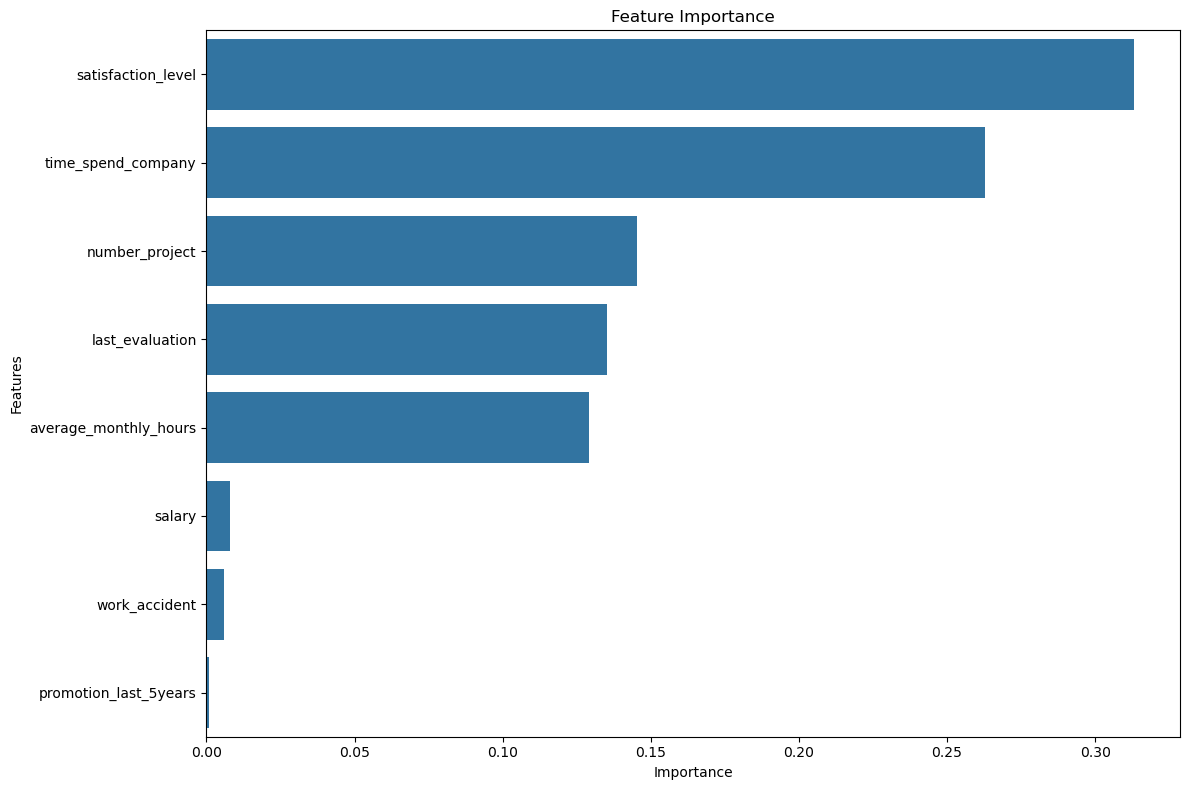

In [92]:
# Feature importance

importances = rf_val.best_estimator_.feature_importances_
features = X_train.columns

importances_df = pd.DataFrame({'Features':features, 'Importance':importances})

importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=importances_df, y='Features', x='Importance')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

* Satisfaction had the most importance in terms of predicting employee turnover. This isn't surporising based on the EDA, and given that employees who are less satisfied are more likely to leave voluntarily.

* Time spent at the company is another feature that had high predictive power. Again, based on the EDA, we found that most employees who left voluntarily spent 4, 5, or 6 years at the company. Very few spent less than 4 years, and no one who spent 7 years or  more left the company.

* The number of projects, performance at last evaluation, and average monthly hours, all had similar ratings of importance in predicting employee turnover. Again, based on the EDA, this was to be expected. Those who left tended to work on more projects, work more hours on average a month, and perform better than those who stayed.

* Salary and promotion in last 5 years had low importance in predicting employee turnover. However, given that a very small proportion were promoted or had high salaries, this was to be expected. The EDA, however, showed that turnover rates for those who were promoted or had high salaries were substantially lower, and so with larger proportions, these features could have higher importance.

  

## Conclusions, Recommendations, and Next Steps

1. Employees who left who worked more than 170 hours are assumed to have left voluntarily, however, this is not a given. Future data collection should verify whether the resigned or were fired. 

2. The final model could correctly identify those who voluntarily left the company 89% of the time.
   
3. Satisfaction was the most important factor in predicting if an employee will leave voluntarily. Therefore, it might be beneficial to measure employee satisfaction once or twice a year, so it can serve as an indicator of those who might leave in the future, and address what might be causing their dissatisfaction.

4. Employees averaging over 250 monthly hours and contributing to more than 5 projects are more likely to leave voluntarily. For those involved in 4+ projects (especially 6–7), there are notable differences in hours worked and last evaluation scores between those who stayed and those who left. Limited promotions and low salaries may reduce incentives to work extra hours, yet project demands require some employees to overwork, leading to burnout and turnover. The company should consider capping workloads at 2–4 projects per employee, or offering promotions and higher pay for heavier loads. Further employee feedback is needed to understand the causes of this disparity.     

5. Most of the focus should be placed on employees who have spent 4, 5 or 6 years, as these are the employees who make up the biggest proportion of those who left the company voluntarily.

   